In [56]:
from qiskit import transpile
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.sparse import diags

from linear_solvers import NumPyLinearSolver, HHL
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from qiskit.quantum_info import Statevector
import sys
import os
os.environ["Q_ALCHEMY_API_KEY"] = "JnvkpMCsyr4nB9nHcwa6CbxqhtZXyF1b"
sys.path.append('..')
from q_alchemy.qiskit import QAlchemyInitialize
from qiskit.opflow import (
    Z,
    I,
    StateFn,
    TensoredOp,
    ExpectationBase,
    CircuitSampler,
    ListOp,
    ExpectationFactory,
    ComposedOp,
)




In [3]:
def calculate_norm(qc: QuantumCircuit, nb: int, nl: int, na:int) -> float:
        """Calculates the value of the euclidean norm of the solution.

        Args:
            qc: The quantum circuit preparing the solution x to the system.

        Returns:
            The value of the euclidean norm of the solution.
        """

        # Create the Operators Zero and One
        zero_op = (I + Z) / 2
        one_op = (I - Z) / 2

        # Norm observable
        observable = one_op ^ TensoredOp((nl + na) * [zero_op]) ^ (I ^ nb)
        norm_2 = (~StateFn(observable) @ StateFn(qc)).eval()
        

        return np.real(np.sqrt(norm_2))

In [4]:
def get_solution_vector(solution, n):
    solution_vector = Statevector(solution.state).data[n:n+8].real
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)

In [99]:
import re

def ibm_decompose(qc):
    state_inst = qc.data[0]
    qubit = str(state_inst[1][0])
    name = re.findall(r"'([^']*)'", qubit)[0]
    qr = QuantumRegister(3, name)
    qc_raw = QuantumCircuit(qr)
    qc_raw.data = [state_inst]
    qc = transpile(qc_raw, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc
    

In [103]:
def q_alchemy_prep(b, fid_loss):
    sp_org = QAlchemyInitialize(b, opt_params={f'max_fidelity_loss':fid_loss})
    qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc

In [121]:
def circuit_depth_generator(b, fid_loss):
    qc = q_alchemy_prep(b, fid_loss)
    depth = qc.depth()
    return depth

## Comparing the circuit depth
Define Matrices and solutions

In [68]:
b_path = 'hhl_data/trial_solution.npy'
data_path = 'hhl_data/hhl_qalchemy_results.csv'

b = np.loadtxt(b_path)


A = np.array([[1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [2.0, 3.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [3.0, 4.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 8.0, 9.0, 0.0, 10.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.0, 12.0]])
ibm = HHL().solve(A, b)
ibm.state.draw()


┌─────────────────┐┌───────┐        ┌──────────┐
q40046_0: ┤0                ├┤9      ├────────┤9         ├
          │                 ││       │        │          │
q40046_1: ┤1 circuit-403651 ├┤10     ├────────┤10        ├
          │                 ││       │        │          │
q40046_2: ┤2                ├┤11     ├────────┤11        ├
          └─────────────────┘│       │┌──────┐│          │
q40047_0: ───────────────────┤0      ├┤8     ├┤0         ├
                             │       ││      ││          │
q40047_1: ───────────────────┤1      ├┤7     ├┤1         ├
                             │       ││      ││          │
q40047_2: ───────────────────┤2      ├┤6     ├┤2         ├
                             │   QPE ││      ││   QPE_dg │
q40047_3: ───────────────────┤3      ├┤5     ├┤3         ├
                             │       ││      ││          │
q40047_4: ───────────────────┤4      ├┤4     ├┤4         ├
                             │       ││  1/x ││          │
q40047_5: ───────────────────┤5      ├┤3     ├┤5         ├
                             │       ││      ││          │
q40047_6: ───────────────────┤6      ├┤2     ├┤6         ├
                             │       ││      ││          │
q40047_7: ───────────────────┤7      ├┤1     ├┤7         ├
                             │       ││      ││          │
q40047_8: ───────────────────┤8      ├┤0     ├┤8         ├
                             └───────┘│      │└──────────┘
  q40048: ────────────────────────────┤9     ├────────────
                                      └──────┘

### IBM's state preparation circuit

/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


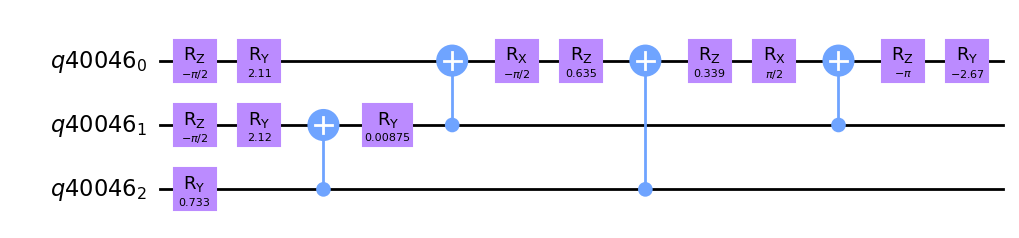

In [101]:
ibm_state = ibm_decompose(ibm.state)
ibm_state.draw('mpl')


### Q-alchemy's state preparation circuit

/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


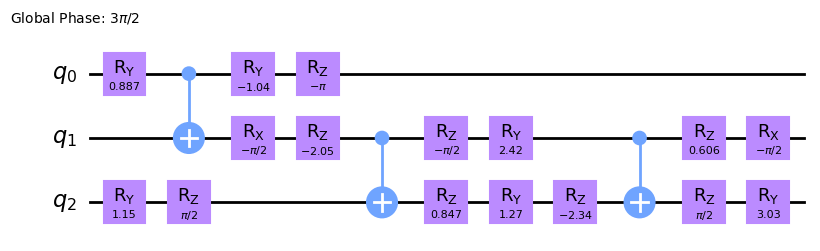

In [104]:
q_alchemy = q_alchemy_prep(b, 0.0)
q_alchemy.draw('mpl')

### Comparing circuit depth

In [108]:
ibm_depth = ibm_state.depth()
qal_depth = q_alchemy.depth()

print(f'IBM circuit depth: {ibm_depth}')
print(f'Q-Alchemy circuit depth: {qal_depth}')

IBM circuit depth: 13
Q-Alchemy circuit depth: 11


### Benchmarking

In [109]:
classical_solution = NumPyLinearSolver().solve(A, b)

In [114]:
import pandas as pd

df = pd.read_csv(data_path, index_col=0)
qal_norms = df['norms'].values
qal_fids = df['fid_loss'].values
ibm_norms = [ibm.euclidean_norm] * len(qal_norms)
classical_norms = [classical_solution.euclidean_norm]*len(qal_norms)

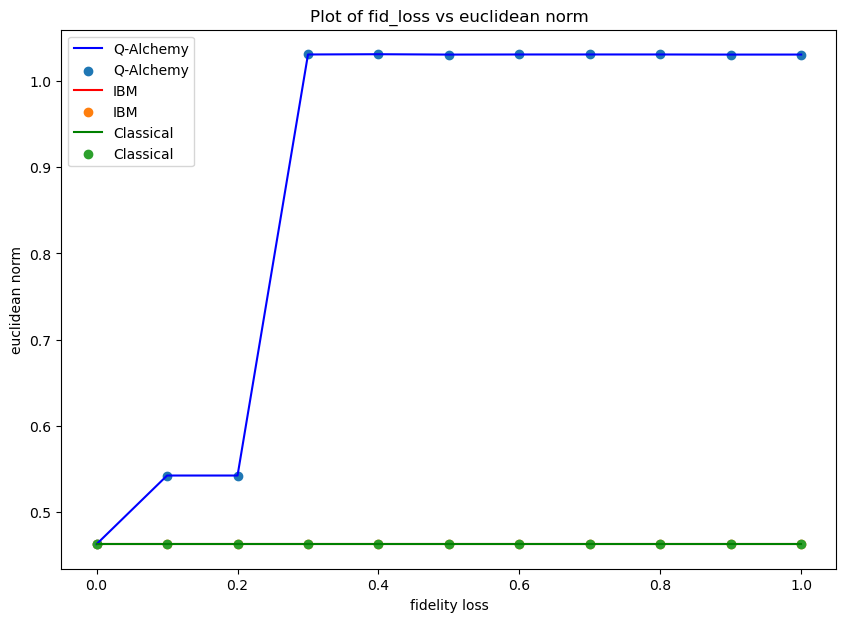

In [120]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, qal_norms, color='blue', label='Q-Alchemy')
plt.scatter(qal_fids, qal_norms, label='Q-Alchemy')

plt.plot(qal_fids, ibm_norms, color='red', label='IBM')
plt.scatter(qal_fids, ibm_norms, label='IBM')

plt.plot(qal_fids, classical_norms, color='green', label='Classical')
plt.scatter(qal_fids, classical_norms, label='Classical')

plt.xlabel('fidelity loss')
plt.ylabel('euclidean norm')
plt.title('Plot of fid_loss vs euclidean norm')
plt.legend()
plt.show()

In [122]:
qal_depths = [circuit_depth_generator(b, fid_loss) for fid_loss in qal_fids]



/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


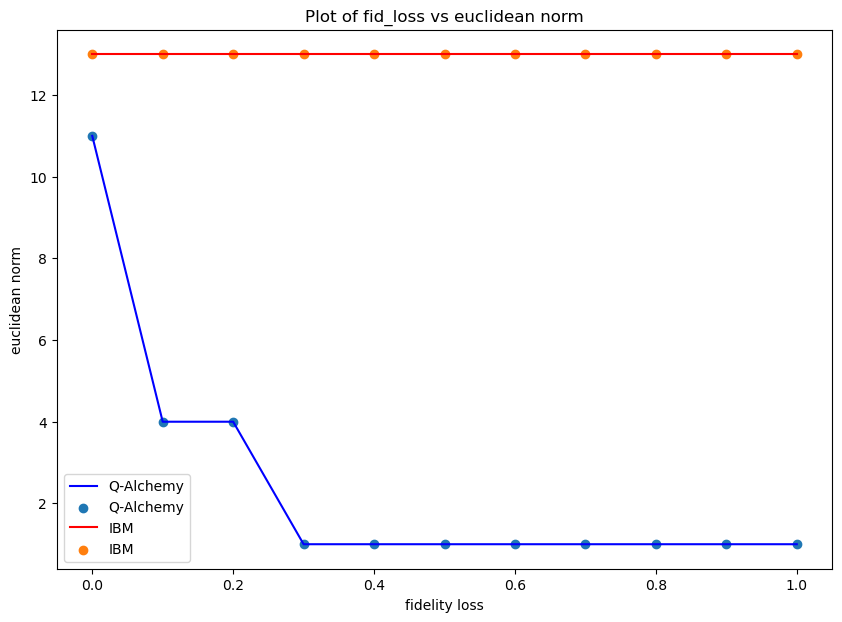

In [123]:
fig: Figure = plt.figure(figsize =(10, 7))

ibm_depths = [ibm_depth]*len(qal_fids)

plt.plot(qal_fids, qal_depths, color='blue', label='Q-Alchemy')
plt.scatter(qal_fids, qal_depths, label='Q-Alchemy')

plt.plot(qal_fids, ibm_depths, color='red', label='IBM')
plt.scatter(qal_fids, ibm_depths, label='IBM')

plt.xlabel('fidelity loss')
plt.ylabel('euclidean norm')
plt.title('Plot of fid_loss vs euclidean norm')
plt.legend()
plt.show()